In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt, exp, log

In [2]:
def norm_cdf(x):
    return 0.5*(1.0 + erf(x / sqrt(2.0)))

def black_scholes_price(S, K, T, r, sigma, option='call'):
    """Closed-form Black–Scholes formula for benchmarking."""
    if T <= 0:
        return max(S - K, 0.0) if (option == 'call') else max(K - S, 0.0)
        
    d1 = (log(S/K) + (r + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    if (option == 'call'):
        return S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    else:
        return K * exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)

FD call price: 109.94025737737039
BS Call (for reference): 109.94028027599839


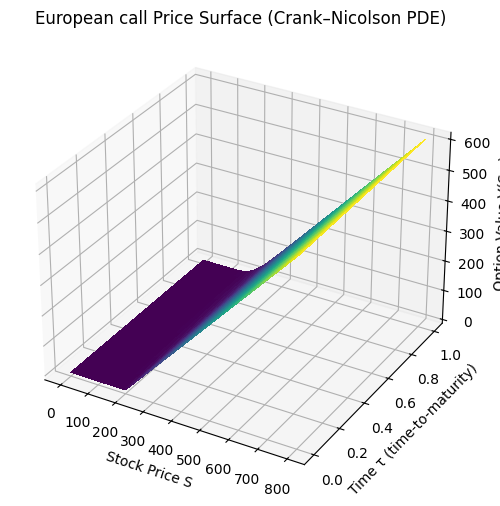

In [3]:
def thomas(a, b, c, d):
    # Solve tridiagonal system: a (len n-1) lower, b (len n) main, c (len n-1) upper, d RHS (len n)
    n = len(b)
    cp = np.empty(n-1)
    dp = np.empty(n)
    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]
    for i in range(1, n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2]) / (b[n-1] - a[n-2]*cp[n-2])
    x = np.empty(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x

def crank_nicolson_european(S0, K, T, r, sigma, Smax, M, N, option='call', rannacher=False):
    # S0: spot; M: number of space steps (S grid has M+1 nodes); N: time steps; option: 'put' or 'call'
    dS = Smax / M
    S = np.linspace(0, Smax, M+1)
    dt = T / N
    t = np.linspace(0, T, N+1)
    V = np.zeros((N+1, M+1))
    # payoff at tau=0 (terminal)
    if option == 'put':
        V[0, :] = np.maximum(K - S, 0.0)
    else:
        V[0, :] = np.maximum(S - K, 0.0)
    # Precompute L-coeffs for interior nodes i=1..M-1
    a = np.zeros(M-1); b = np.zeros(M-1); c = np.zeros(M-1)
    for i in range(1, M):
        Si = S[i]
        A = 0.5 * sigma*sigma * Si*Si
        B = r * Si
        a[i-1] = A / (dS**2) - B / (2*dS)
        b[i-1] = -2*A / (dS**2) - r
        c[i-1] = A / (dS**2) + B / (2*dS)
    # Matrices for CN: left (A_mat) = I - 0.5 dt L ; right (B_mat) = I + 0.5 dt L
    alpha_L = -0.5 * dt * a    # lower diag for left matrix (note sign)
    beta_L  = 1.0 - 0.5 * dt * b
    gamma_L = -0.5 * dt * c
    alpha_R = 0.5 * dt * a
    beta_R  = 1.0 + 0.5 * dt * b
    gamma_R = 0.5 * dt * c

    # Rannacher smoothing: do two half-steps with implicit Euler (optional)
    tau = 0.0
    steps = N
    if rannacher:
        if N < 2:
            raise ValueError("N must be >= 2 to use Rannacher smoothing")
        # do two implicit Euler half-steps: Δτ = dt/2 twice
        curr_V = V[0, :].copy()
        for sub in range(2):
            delta = dt/2.0
            # left matrix for BE: I - delta*L  -> diag arrays
            AL_low = -delta * a
            AL_main = 1.0 - delta * b
            AL_up = -delta * c
            # rhs is V (no operator)
            # Build RHS for interior:
            rhs = np.empty(M-1)
            for i in range(1, M):
                rhs[i-1] = curr_V[i]
            # include boundary values at new tau (we must use boundary at tau+delta)
            tau_new = tau + delta
            if option == 'call':
                V0 = 0.0
                VM = Smax - K*exp(-r * tau_new)
            else:
                V0 = K * exp(-r * tau_new)
                VM = 0.0
            # adjust rhs for boundaries
            rhs[0]   -= AL_low[0] * V0   # first interior depends on V0
            rhs[-1]  -= AL_up[-1] * VM   # last interior depends on VM
            
            lower = AL_low[1:]
            diag = AL_main
            upper = AL_up[:-1]
            
            V_int = thomas(lower, diag, upper, rhs)
            curr_V[1:M] = V_int
            curr_V[0] = V0; curr_V[M] = VM
            tau = tau_new
        V[1, :] = curr_V.copy()
        steps_comp = 1  # no. of full steps taken by rannacher

    # Main CN time loop
    for n in range(steps_comp, steps):
        prev_V = V[n, :].copy()
        tau_new = tau + dt
        # compute boundary at tau and tau_new (we use tau_new for imposing Dirichlet on RHS adjustment)
        if option == 'call':
            V0_new = 0.0
            VM_new = Smax - K*exp(-r * tau_new)
        else:
            V0_new = K * exp(-r * tau_new)
            VM_new = 0.0
        # Form RHS = B * V_old (interior)
        rhs = np.empty(M-1)
        for i in range(1, M):
            rhs[i-1] = alpha_R[i-1]*prev_V[i-1] + beta_R[i-1]*prev_V[i] + gamma_R[i-1]*prev_V[i+1]
        # Add boundary contributions (because V[0] and V[M] known)
        rhs[0]  -= alpha_L[0] * V0_new  # move left boundary to RHS of left system
        rhs[-1] -= gamma_L[-1] * VM_new

        lower = alpha_L[1:]
        diag = beta_L
        upper = gamma_L[:-1]
        # Now solve left system A * V_new_interior = rhs  where left A has diagonals alpha_L, beta_L, gamma_L
        V_int = thomas(lower, diag, upper, rhs)
        V[n+1, 1:M] = V_int
        V[n+1, 0] = V0_new; V[n+1, M] = VM_new
        tau = tau_new

    # interpolate to find value at S0
    if S0 <= 0:
        val = V[-1, 0]
    elif S0 >= Smax:
        val = V[-1, -1]
    else:
        i = int(S0 / dS)
        # linear interpolation
        val = V[-1, i] + (V[-1, i+1] - V[-1, i])*(S0 - S[i]) / dS

    return val, V, S, t


if __name__ == '__main__':
    S0 = 300.0; K = 200.0; T = 1.0; r = 0.05; sigma = 0.2
    Smax = 4*K
    M = 400     # spatial steps
    N = 400     # time steps
    option = 'call'
    price_fd, V_grid, S_grid, t_grid = crank_nicolson_european(S0, K, T, r, sigma, Smax, M, N, option=option, rannacher=True)
    price_bs = black_scholes_price(S0, K, T, r, sigma, option=option)  # for call; or implement put by parity
    print("FD call price:", price_fd)
    print("BS Call (for reference):", price_bs)

    # 3D Surface plot
    S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_mesh, t_mesh, V_grid, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time τ (time-to-maturity)')
    ax.set_zlabel('Option Value V(S,τ)')
    ax.set_title(f'European {option} Price Surface (Crank–Nicolson PDE)')
    plt.show()

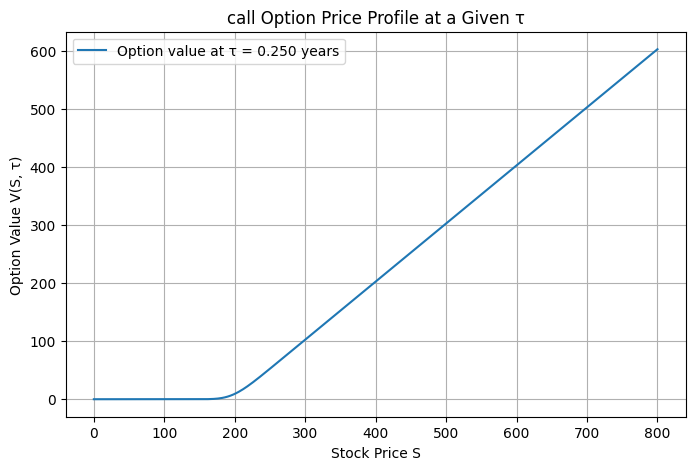

In [4]:
tau_target = 0.25 # years before maturity (since τ = T - t)
t_grid = np.linspace(0, T, N+1)
idx = np.argmin(np.abs(t_grid - tau_target))

plt.figure(figsize=(8,5))
plt.plot(S_grid, V_grid[idx, :], label=f'Option value at τ = {t_grid[idx]:.3f} years')
plt.xlabel('Stock Price S')
plt.ylabel('Option Value V(S, τ)')
plt.title(f'{option} Option Price Profile at a Given τ')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
import plotly.io as pio
pio.renderers.default = "browser"

# Build the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=S_grid,         # Stock price axis
    y=t_grid,         # Time axis
    z=V_grid,         # Option values
    colorscale='Viridis',
    contours = {
        "z": {"show": True, "usecolormap": True, "highlightcolor": "limegreen", "project_z": True}
    }
)])

fig.update_layout(
    title=f'European {option} Price Surface (Crank–Nicolson PDE)',
    scene=dict(
        xaxis_title='Stock Price S',
        yaxis_title='Time t',
        zaxis_title='Option Value V(S, t)',
        xaxis=dict(nticks=8, range=[0, Smax]),
        yaxis=dict(nticks=8, range=[0, T]),
        zaxis=dict(nticks=8),
    ),
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=50, t=80),
)

fig.show()
